# Falcon Preimage Attack (HARDWARE)

---
**THIS IS NOT THE COMPLETE TUTORIAL - see file with `(MAIN)` in the name.**

---

First you'll need to select which hardware setup you have. You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. An alternative for `'CWLITEXMEGA'` targets is `'AVRCRYPTOLIB'`. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

The following code will build the firmware for the target.

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

(ChipWhisperer Other WARNING|File __init__.py:69) ChipWhisperer update available! See https://chipwhisperer.readthedocs.io/en/latest/installing.html for updating instructions


INFO: Found ChipWhisperer😍


In [3]:
%%sh -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-falcon
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CW308_STM32F3 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
C:/Users/DAVIDK~1/CHIPWH~1/cw/home/portable/avrgcc/bin/make clean_objs .dep 
make[1]: Entering directory 'C:/Users/davidking/ChipWhisperer5_64/cw/home/portable/chipwhisperer/hardware/victims/firmware/simpleserial-falcon'
Building for platform CW308_STM32F3 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-falcon-CW308_STM32F3.hex
rm -f -- simpleserial-falcon-CW308_STM32F3.eep
rm -f -- simpleserial-falcon-CW308_STM32F3.cof
rm -f -- simpleserial-falcon-CW308_STM32F3.elf
rm -f -- simpleserial-falcon-CW308_STM32F3.map
rm -f -- simpleserial-falcon-CW308_STM32F3.sym
rm -f -- simpleserial-falcon-CW308_STM32F3.lss
rm -f -- objdir-CW308_STM32F3/*.o
rm -f -- objdir-CW308_STM32F3/*.lst
rm -f -- simpleserial-falcon.s fft.s fpr.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s 

.././crypto/tiny-AES128-C/aes.c:687:13: warning: 'InvSubBytesMasked' defined but not used [-Wunused-function]
  687 | static void InvSubBytesMasked(void)
      |             ^~~~~~~~~~~~~~~~~
.././crypto/tiny-AES128-C/aes.c:474:13: warning: 'SubBytes' defined but not used [-Wunused-function]
  474 | static void SubBytes(void)
      |             ^~~~~~~~
.././crypto/tiny-AES128-C/aes.c:302:13: warning: 'InitMaskingDecrypt' defined but not used [-Wunused-function]
  302 | static void InitMaskingDecrypt(const uint8_t *RoundKey, uint8_t *RoundKeyMasked, uint8_t *mask)
      |             ^~~~~~~~~~~~~~~~~~


In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-falcon/simpleserial-falcon-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 23003 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 23003 bytes


In [11]:
LOGN = 4 
DIM = (1 << LOGN)
nb_challenge = 80000
scope.adc.samples = 24000

In [12]:
import struct

def decompose_bytes(c):
    return bytearray(list(struct.pack('<d', c)))

def compose_float64(byte_list):
    return struct.unpack('<d', bytes(byte_list))[0] 

def get_trace(challenge):
    
    # setup coefficients of f(challenge)
    for idx in range(DIM):
        idx_hi = (idx >> 8) & 0xFF  # High byte
        idx_lo = idx & 0xFF         # Low byte


        text = bytearray([idx_hi, idx_lo]) + decompose_bytes(challenge[idx])
        scope.arm()

        target.simpleserial_write('k', text)
#         print([ord(chr(b)) for b in text])

        response = target.simpleserial_read('r', 8)
        response_ints = [ord(chr(b)) for b in response]
#         print("Response:", response_ints)
        
    # run scope
    test_idx = 15

    test_idx_hi = (test_idx >> 8) & 0xFF  # High byte
    test_idx_lo = test_idx & 0xFF         # Low byte
    target.simpleserial_write('p', bytearray([test_idx_hi, test_idx_lo]))

    response = target.simpleserial_read('r', 8)
#     response_ints = [ord(chr(b)) for b in response]
    response_ints = compose_float64(response)
#     print("check response:", response_ints)

    ret = scope.capture()
    if ret:
        print("Target timed out!")
        return []
    else:
        return scope.get_last_trace()

In [13]:
import h5py
from random import gauss, choices
import string

file = h5py.File("traces_cw.hdf5", "a")

key = [-1, 1, -1, -1, 1, -3, -11, 9, -2, 2, -8, -4, 2, 0, 1, -2]
logn = 4

key_group = file.create_group(''.join(choices(string.ascii_uppercase + string.digits, k=8)))
key_group.attrs.create("key", key)
key_group.attrs.create("logn", logn)

In [ ]:
from tqdm.notebook import trange
import numpy as np

def get_random_challenge():
        from random import uniform
        return [uniform(-512, 512) for i in range(DIM)]

trace_array = []
challenge_array = []


for i in trange(nb_challenge, desc='Capturing traces'):
    challenge = get_random_challenge()
    trace = get_trace(challenge)
    if trace.any:
        trace_array.append(trace)
        challenge_array.append(challenge)
        
        new = np.array(trace_array, dtype=np.float64)
        dataset = key_group.create_dataset(name=str(i*nb_challenge), data=new[0])
        dataset.attrs.create("challenge", challenge)
#         print(challenge)

file.close()

Capturing traces:   0%|          | 0/80000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


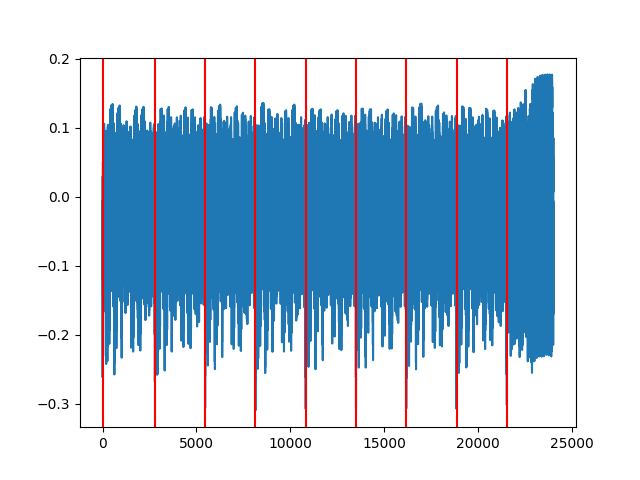

In [112]:
%matplotlib notebook
import matplotlib.pylab as plt

sub_trace_array = trace_array[:20]

trace_avg = sub_trace_array[0]
for i in range(1, len(sub_trace_array)):
    trace_avg += sub_trace_array[i]
trace_avg /= len(sub_trace_array)

def find_round_indexes(trace):
    start = 0
    end = 18900
    num_rounds = 9
    window = 200

    d = (end - start) / (num_rounds - 2)

    round_indexes = [int(start + i * d) for i in range(num_rounds)]

    for i in range(num_rounds):
        center = round_indexes[i]
        left = max(0, center - window)
        right = min(len(trace), center + window)
        local_min = np.argmin(trace[left:right])
        round_indexes[i] = left + local_min

    return round_indexes

round_indexes =  find_round_indexes(sub_trace_array[1])

plt.figure(0)
plt.plot(trace_avg)
for i in round_indexes:
    plt.axvline(x=i, color='r')
plt.show()

<IPython.core.display.Javascript object>


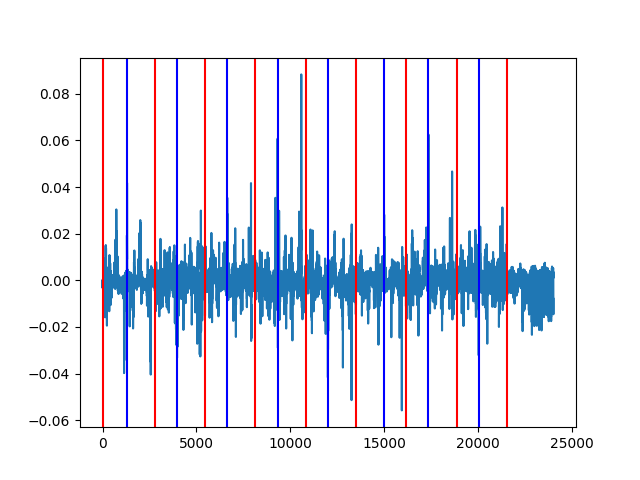

In [113]:
def find_middles(trace, round_indexes):
    num_rounds = 8
    window = 200
    
    middles = [(round_indexes[i]+round_indexes[i+1])/2 for i in range(num_rounds)]
    for i in range(num_rounds):
        center = int(middles[i])
        left = max(0, center - window)
        right = min(len(trace), center + window)
        local_max = np.argmax(abs(trace[left:right]))
        middles[i] = left + local_max  # 加回 offset

    return middles

middles = find_middles(sub_trace_array[1]-trace_avg, round_indexes)

plt.figure(1)
plt.plot(sub_trace_array[1]-trace_avg)
    
for i in round_indexes:
    plt.axvline(x=i, color='r')
    
for i in middles:
    plt.axvline(x=i, color='b')
plt.show()

<IPython.core.display.Javascript object>


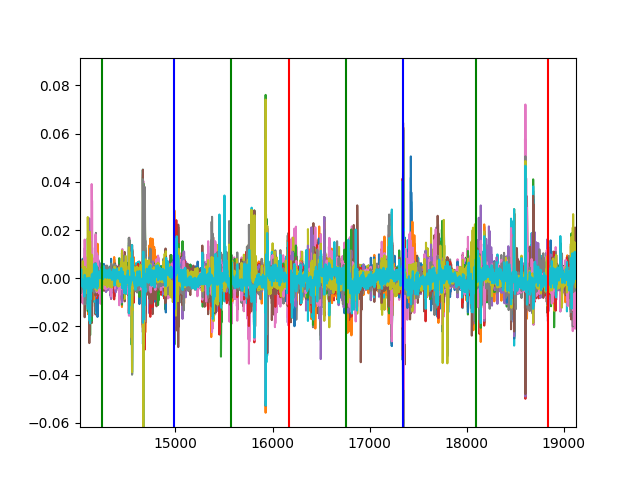

In [116]:
plt.figure(2)

for t in sub_trace_array:
    plt.plot(t-trace_avg)

for i in round_indexes:
    plt.axvline(x=i, color='r')  
    
for i in middles:
    plt.axvline(x=i, color='b')
    
for i in splits:
    plt.axvline(x=i, color='g')
plt.show()

<IPython.core.display.Javascript object>


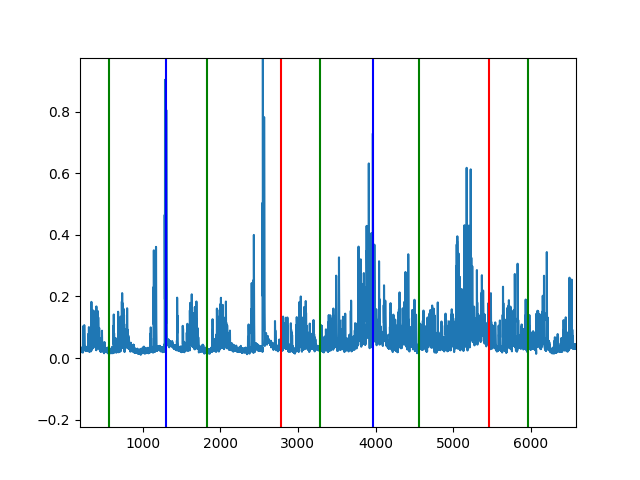

In [142]:
def find_splits(trace, round_indexes, middles):
    num_rounds = 8
    window = 110
    
    splits_left = [(round_indexes[i]+middles[i])/2 for i in range(num_rounds)]
    splits_right = [(round_indexes[i+1]+middles[i])/2 for i in range(num_rounds)]
    
    for i in range(num_rounds):
        center = int(splits_left[i])
        left = center-300
        local_min = 1e10
        local_min_idx = center
        for j in range(left, center):
        
            integral = sum(trace[j-window:j+window])
            if integral < local_min:
                local_min = integral
                local_min_idx = j
                
        splits_left[i] = local_min_idx 
        
    for i in range(num_rounds):
        center = int(splits_right[i])
        left = center-300
        local_min = 1e10
        local_min_idx = center
        for j in range(left, center):
        
            integral = sum(trace[j-window:j+window])
            if integral < local_min:
                local_min = integral
                local_min_idx = j
                
        splits_right[i] = local_min_idx  

    return splits_left + splits_right

splits = find_splits(sum(abs(sub_trace_array-trace_avg)), round_indexes, middles)

plt.figure(3)

# for t in sub_trace_array:
#     plt.plot(t-trace_avg)
plt.plot(sum(abs(sub_trace_array-trace_avg)))

for i in round_indexes:
    plt.axvline(x=i, color='r')
    
for i in middles:
    plt.axvline(x=i, color='b')
    
for i in splits:
    plt.axvline(x=i, color='g')
plt.show()

<IPython.core.display.Javascript object>


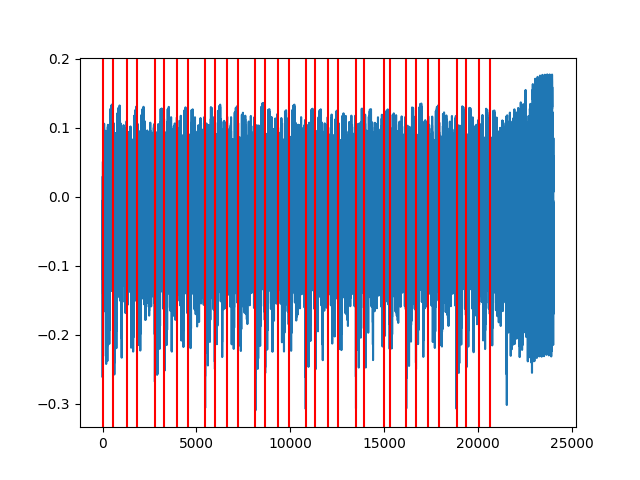

[5, 2785, 5461, 8137, 10813, 13489, 16165, 18841, 1305, 3965, 6637, 9317, 11993, 14989, 17345, 20021, 567, 3283, 5959, 8633, 11311, 13939, 16662, 19336, 1835, 4555, 7231, 9906, 12543, 15277, 17882, 20611]


In [160]:
indexes = round_indexes[:8]
indexes += middles
indexes += splits

plt.figure(4)
plt.plot(trace_avg)
for i in indexes:
    plt.axvline(x=i, color='r')
plt.show()
print(indexes)

We don't need the hardware anymore, so we'll disconnect:

In [16]:
scope.dis()
target.dis()

(ChipWhisperer Scope ERROR|File naeusbchip.py:108) Scope already disconnected!
